# Cryto price forecasting using Autoformer 

In [110]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
from transformers import AutoModel, AutoTokenizer 
from datetime import datetime
import ta



In [111]:
#Obtener el dataset
data = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.drop(['Adj Close', 'Open', 'High', 'Low'], axis=1, inplace=True)
data


,Close,Volume
Date,,
2020-01-01,7200.174316,1.856566e+10
2020-01-02,6985.470215,2.080208e+10
2020-01-03,7344.884277,2.811148e+10
2020-01-04,7410.656738,1.844427e+10
2020-01-05,7411.317383,1.972507e+10
...,...,...
2024-04-19,63843.570313,4.992043e+10
2024-04-20,64994.441406,2.309749e+10
2024-04-21,64926.644531,2.050664e+10


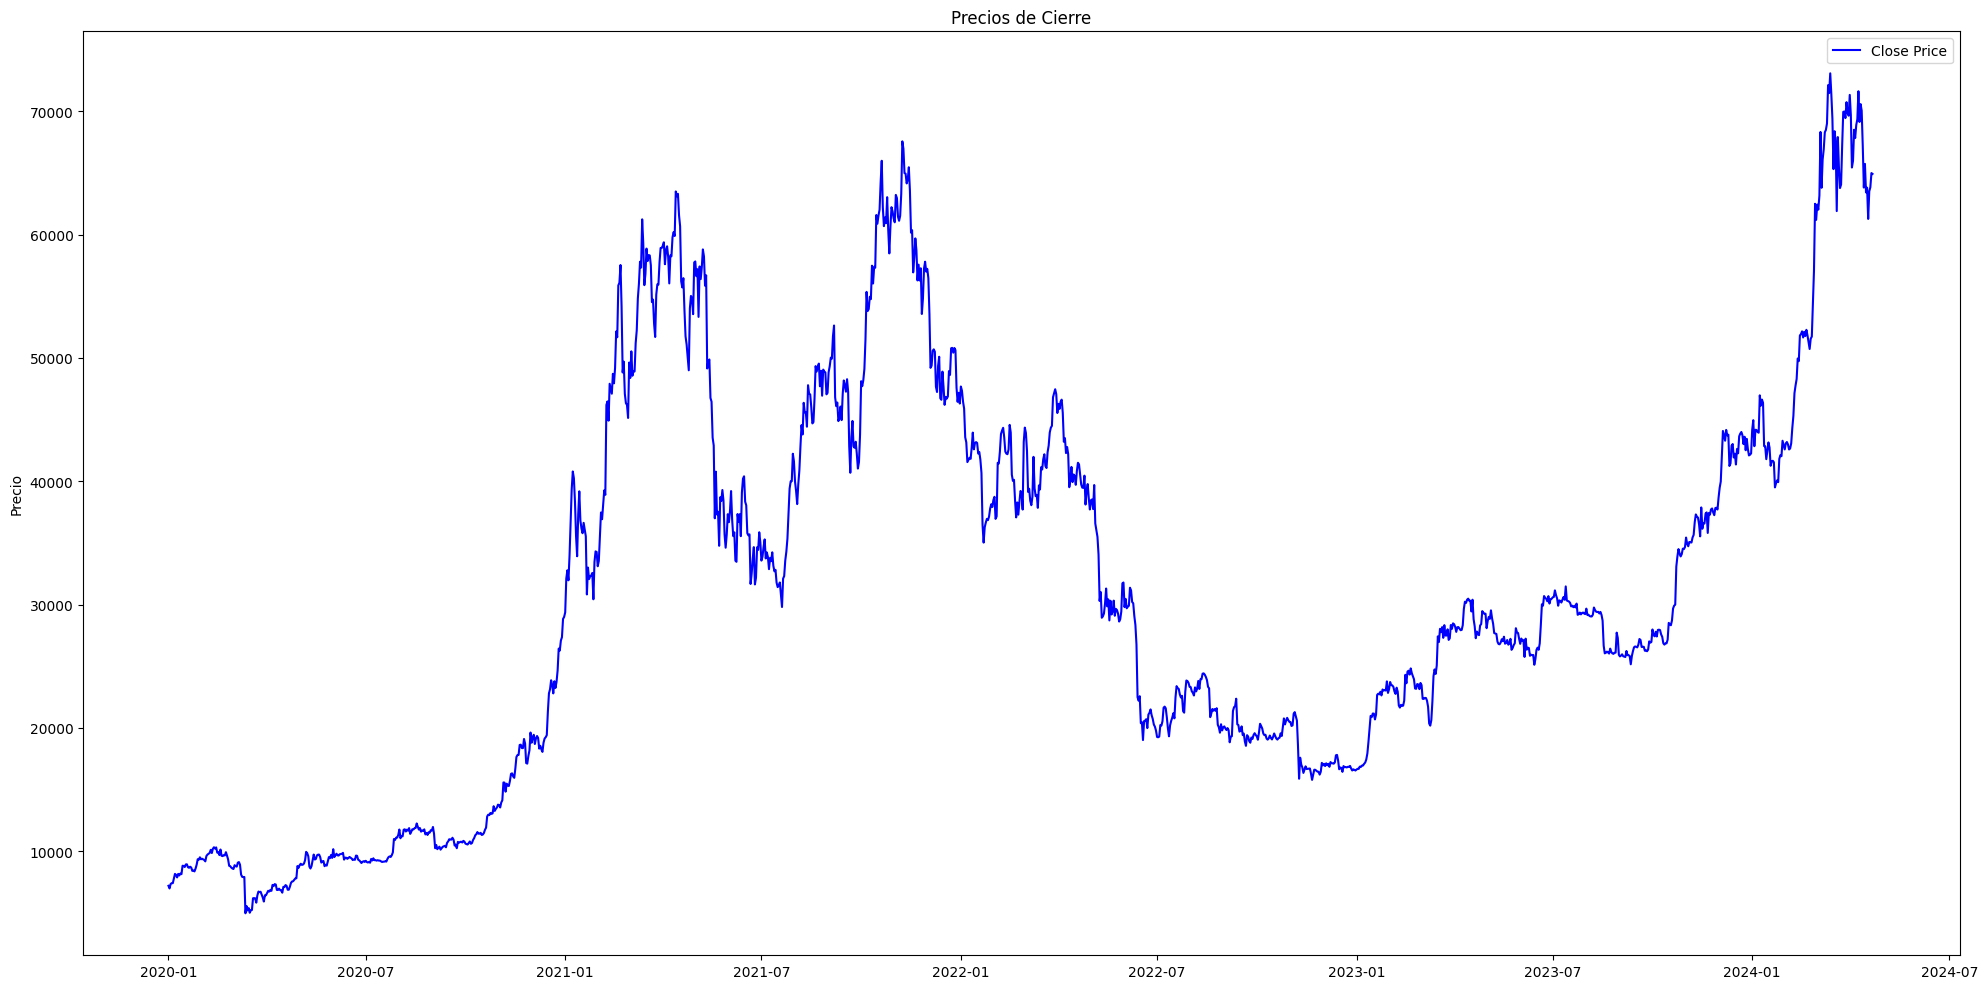

In [112]:
# Visualizacion
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 1, 1)  # Para precios y medias móviles
ax1.plot(data.index, data['Close'], label='Close Price', color='blue')

ax1.set_title('Precios de Cierre')
ax1.set_ylabel('Precio')
ax1.legend()
plt.tight_layout()
plt.show()


## Calculamos Indicadores

In [113]:
# Calcular indicadores
# Añadir medias móviles
data['sma'] = ta.trend.sma_indicator(data['Close'], window=30)
data['ema20'] = ta.trend.ema_indicator(data['Close'], window=20)
data['ema50'] = ta.trend.ema_indicator(data['Close'], window=50)
data['ema200'] = ta.trend.ema_indicator(data['Close'], window=200)


# Añadir RSI
data['rsi'] = ta.momentum.rsi(data['Close'], window=14)

# Añadir MACD
macd = ta.trend.MACD(data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['macd'] = macd.macd()
data['macd_signal'] = macd.macd_signal()

# # Añadir Bandas de Bollinger
# bollinger = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
# data['bollinger_hband'] = bollinger.bollinger_hband()
# data['bollinger_lband'] = bollinger.bollinger_lband()
# data['bollinger_mavg'] = bollinger.bollinger_mavg()

# Ver los datos con indicadores añadidos
print(data[['Close', 'sma', 'ema20', 'ema50', 'ema200', 'rsi', 'macd', 'macd_signal']].head())

                  Close  sma  ema20  ema50  ema200  rsi  macd  macd_signal
Date                                                                      
2020-01-01  7200.174316  NaN    NaN    NaN     NaN  NaN   NaN          NaN
2020-01-02  6985.470215  NaN    NaN    NaN     NaN  NaN   NaN          NaN
2020-01-03  7344.884277  NaN    NaN    NaN     NaN  NaN   NaN          NaN
2020-01-04  7410.656738  NaN    NaN    NaN     NaN  NaN   NaN          NaN
2020-01-05  7411.317383  NaN    NaN    NaN     NaN  NaN   NaN          NaN


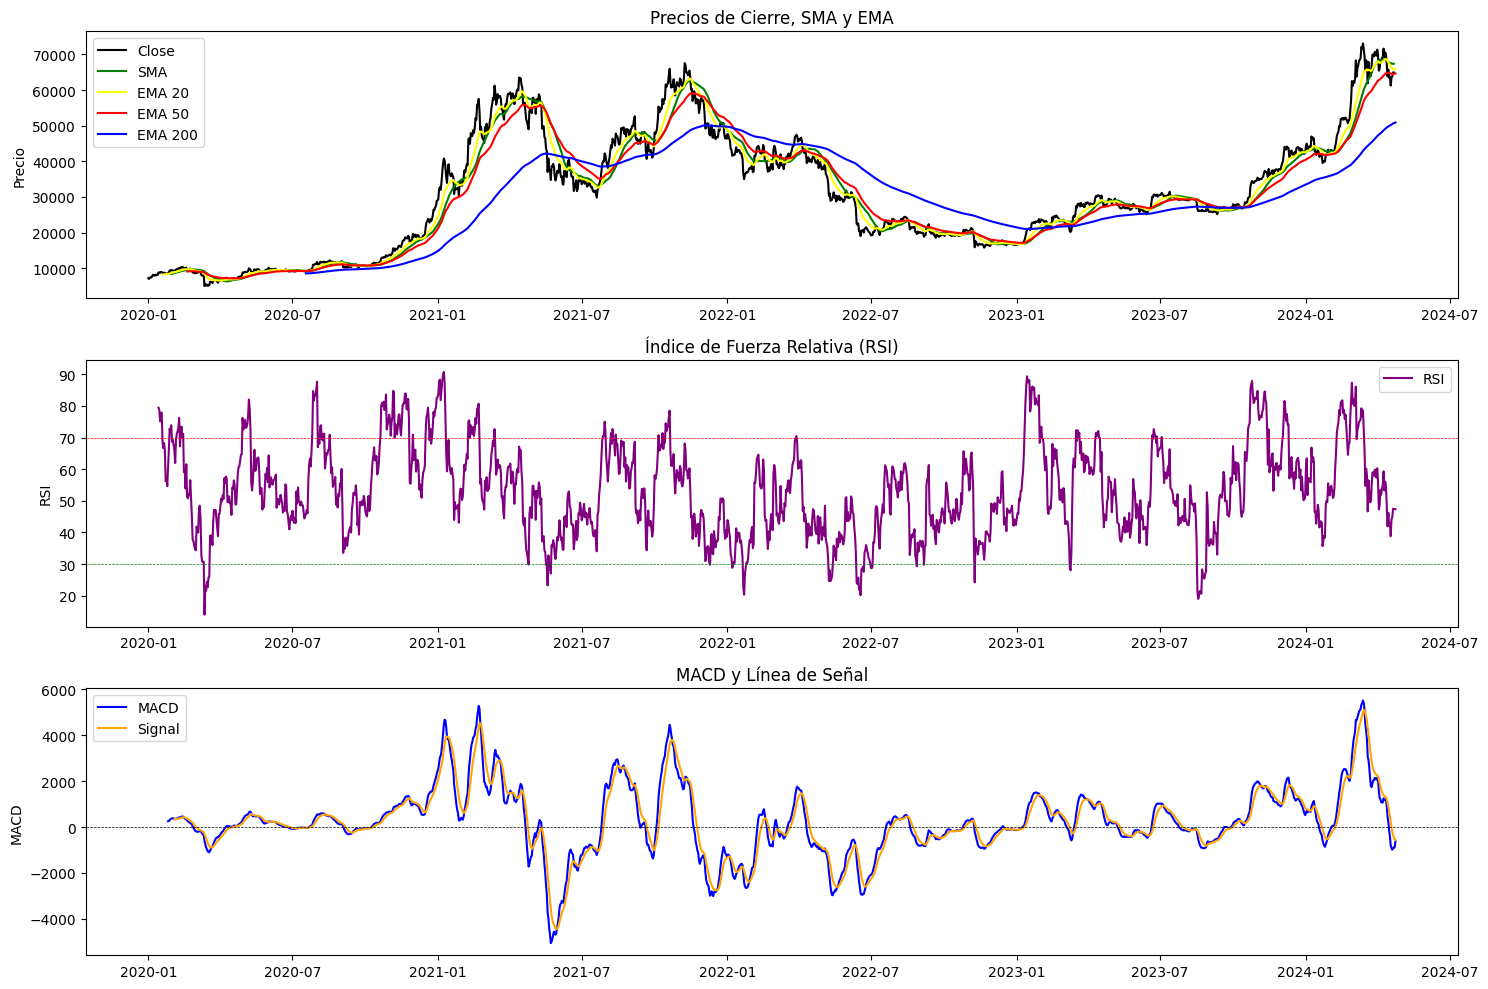

In [114]:
# Configurar el tamaño de la figura
plt.figure(figsize=(15, 10))
# Crear subplots
ax1 = plt.subplot(3, 1, 1)  # Para precios y medias móviles
ax2 = plt.subplot(3, 1, 2, sharex=ax1)  # Para RSI
ax3 = plt.subplot(3, 1, 3, sharex=ax1)  # Para MACD
# Gráfico de precios, SMA y EMA
ax1.plot(data.index, data['Close'], label='Close', color='black')
ax1.plot(data.index, data['sma'], label='SMA', color='green')
ax1.plot(data.index, data['ema20'], label='EMA 20', color='yellow')
ax1.plot(data.index, data['ema50'], label='EMA 50', color='red')
ax1.plot(data.index, data['ema200'], label='EMA 200', color='blue')
ax1.set_title('Precios de Cierre, SMA y EMA')
ax1.set_ylabel('Precio')
ax1.legend()

# Gráfico de RSI
ax2.plot(data.index, data['rsi'], label='RSI', color='purple')
ax2.axhline(70, linestyle='--', color='red', linewidth=0.5)
ax2.axhline(30, linestyle='--', color='green', linewidth=0.5)
ax2.set_title('Índice de Fuerza Relativa (RSI)')
ax2.set_ylabel('RSI')
ax2.legend()

# Gráfico de MACD
ax3.plot(data.index, data['macd'], label='MACD', color='blue')
ax3.plot(data.index, data['macd_signal'], label='Signal', color='orange')
ax3.axhline(0, linestyle='--', color='black', linewidth=0.5)
ax3.set_title('MACD y Línea de Señal')
ax3.set_ylabel('MACD')
ax3.legend()

# Ajustar el layout y mostrar los gráficos
plt.tight_layout()
plt.show()

In [115]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [116]:
data1 = data.dropna()
data1

,Close,Volume,sma,ema20,ema50,ema200,rsi,macd,macd_signal
Date,,,,,,,,,
2020-07-18,9159.040039,1.225260e+10,9245.300977,9231.180849,9213.858133,8546.818671,45.716689,-38.296540,-34.040731
2020-07-19,9185.817383,1.293900e+10,9241.894271,9226.860519,9212.758496,8553.176867,47.091899,-37.173502,-34.667285
2020-07-20,9164.231445,1.375560e+10,9236.290625,9220.895845,9210.855474,8559.257012,46.078480,-37.591954,-35.252219
2020-07-21,9374.887695,1.806958e+10,9238.665885,9235.561736,9217.288110,8567.372740,56.024356,-20.686916,-32.339158
2020-07-22,9525.363281,1.653225e+10,9234.554069,9263.161883,9229.369490,8576.904984,61.488782,4.797271,-24.911873
...,...,...,...,...,...,...,...,...,...
2024-04-17,61276.691406,4.191525e+10,67461.216016,66584.149096,64608.905851,50200.847537,38.816389,-800.914302,217.331381
2024-04-18,63512.753906,3.600631e+10,67514.548698,66291.635268,64565.919500,50333.304317,44.081793,-925.197970,-11.174489
2024-04-19,63843.570313,4.992043e+10,67378.878646,66058.486225,64537.592081,50467.734825,44.838143,-985.637734,-206.067138


In [117]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data1, lookback)
shifted_df

,Close,Volume,sma,ema20,ema50,ema200,rsi,macd,macd_signal,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,,,,,,,,,
2020-07-25,9677.113281,1.661007e+10,9254.120605,9350.957318,9271.246598,8607.103263,65.432086,66.987114,11.474648,9536.892578,9581.072266,9525.363281,9374.887695,9164.231445,9185.817383,9159.040039
2020-07-26,9905.166992,2.050800e+10,9278.862240,9403.739192,9296.106221,8620.019320,71.309597,102.129464,29.605611,9677.113281,9536.892578,9581.072266,9525.363281,9374.887695,9164.231445,9185.817383
2020-07-27,10990.873047,3.535975e+10,9343.711654,9554.894797,9362.567666,8643.609905,84.671687,215.107806,66.706050,9905.166992,9677.113281,9536.892578,9581.072266,9525.363281,9374.887695,9164.231445
2020-07-28,10912.823242,2.876655e+10,9402.686361,9684.221316,9423.362002,8666.189142,81.724981,294.946034,112.354047,10990.873047,9905.166992,9677.113281,9536.892578,9581.072266,9525.363281,9374.887695
2020-07-29,11100.467773,2.461725e+10,9466.340137,9819.101931,9489.130856,8690.410820,83.235538,369.104939,163.704225,10912.823242,10990.873047,9905.166992,9677.113281,9536.892578,9581.072266,9525.363281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17,61276.691406,4.191525e+10,67461.216016,66584.149096,64608.905851,50200.847537,38.816389,-800.914302,217.331381,63811.863281,63426.210938,65738.726563,63821.472656,67195.867188,70060.609375,70587.882813
2024-04-18,63512.753906,3.600631e+10,67514.548698,66291.635268,64565.919500,50333.304317,44.081793,-925.197970,-11.174489,61276.691406,63811.863281,63426.210938,65738.726563,63821.472656,67195.867188,70060.609375
2024-04-19,63843.570313,4.992043e+10,67378.878646,66058.486225,64537.592081,50467.734825,44.838143,-985.637734,-206.067138,63512.753906,61276.691406,63811.863281,63426.210938,65738.726563,63821.472656,67195.867188


## Normalizamos el DataSet 

In [120]:
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(shifted_df)
data_scaled

array([[-1.        , -0.93473554, -1.        , ..., -1.        ,
        -0.99932459, -1.        ],
       [-0.9928066 , -0.91218049, -0.99916556, ..., -0.99340868,
        -1.        , -0.99916222],
       [-0.95856065, -0.826242  , -0.99697844, ..., -0.98870038,
        -0.99340868, -0.99983758],
       ...,
       [ 0.70854893, -0.74198779,  0.96032213, ...,  0.77018594,
         0.71019608,  0.81579405],
       [ 0.74485035, -0.89719663,  0.95976346, ...,  0.69782855,
         0.77018594,  0.71021961],
       [ 0.74271187, -0.91218832,  0.96105392, ...,  0.70989541,
         0.69782855,  0.7702046 ]])

## Entrenamiento del modelo